# 5. Simulación de Data Drift y Evaluación de Pérdida de Performance

## Introducción

En esta sección se simula un escenario de **data drift**, entendido como un cambio en la distribución de los datos de entrada respecto al conjunto utilizado durante el entrenamiento del modelo. Detectar este fenómeno es fundamental en MLOps, ya que los modelos pueden degradarse con el tiempo incluso si su arquitectura permanece intacta.

De acuerdo con las instrucciones del proyecto, esta actividad incluye:

1. Generar un conjunto de datos de monitoreo con una distribución alterada.
2. Evaluar el desempeño del modelo en este nuevo conjunto.
3. Registrar resultados, gráficos, umbrales y criterios de alerta.

---

## 1. Generación del Dataset con Drift

Para simular data drift de manera controlada, se crearon **versiones modificadas** de las variables originales aplicando:

- **Desplazamiento de medias** en columnas numéricas.
- **Aumento de varianza** mediante la adición de ruido gaussiano.
- **Alteración de frecuencias categóricas** simulando efectos demográficos, cambios de comportamiento o condiciones estacionales.

Este procedimiento imita condiciones reales donde:
- Cambian hábitos poblacionales.
- Entran nuevos segmentos no observados durante el entrenamiento.
- Ocurre deterioro en sensores o cambios en el contexto operativo.

El resultado es un dataset `df_drift` que sirve como conjunto de monitoreo.

---

## 2. Detección de Drift Numérico (Prueba KS)

Aplicamos la prueba de Kolmogorov–Smirnov (KS) para comparar cada variable numérica entre el dataset original y el dataset con drift.

**Criterios utilizados:**
- **p-value < 0.05** → diferencia estadísticamente significativa.
- **KS statistic > 0.10** → magnitud relevante del cambio en distribución.

Variables que cumplen ambos criterios son clasificadas como variables con **drift numérico fuerte**.

Este análisis permite cuantificar si las distribuciones se alejaron lo suficiente como para representar un riesgo operativo para el modelo.

---

## 3. Detección de Drift Categórico (Chi-cuadrada)

Para variables categóricas, utilizamos la prueba Chi-cuadrada (χ²), que compara si las frecuencias categóricas cambiaron entre ambos conjuntos.

**Criterios utilizados:**
- **p-value < 0.05** → evidencia de drift categórico significativo.

Este enfoque revela si cambios en proporciones de etiquetas o categorías afectan la estabilidad del modelo.

---

## 4. Evaluación del Modelo: Probabilidades y Métricas

Para determinar si el data drift resulta en **performance drift**, evaluamos el modelo en:

- `df_original`  
- `df_drift`

Se analizaron:

- Matriz de probabilidades (`predict_proba`)
- Curvas ROC
- Curvas PR (Precision-Recall)
- Métricas cuantitativas por clase

Estos elementos permiten observar si la separabilidad del modelo se deteriora o si se mantienen los patrones de predicción.

---

## 5. Curvas ROC y PR

Las curvas ROC y PR permiten visualizar la calidad de la clasificación binaria para una clase objetivo seleccionada (one-vs-rest).

### Observaciones

Aunque se introdujo drift de manera intencional, las curvas ROC y PR mostraron:

- **AUC ≈ 1.0**
- **AP ≈ 1.0**
- Curvas suavemente verticales y muy cerradas

Esto indica que:

1. El modelo original está altamente optimizado.
2. El drift introducido no afecta significativamente las variables que más pesan en el modelo.
3. La estructura de decisión del modelo es robusta ante las perturbaciones aplicadas.

---

## 6. Probabilidades Predichas por el Modelo

Para un análisis más detallado, se graficaron histogramas de las **probabilidades predichas** por el modelo (via `predict_proba`) tanto en datos originales como con drift.

Este análisis permite observar:

- Cambios en calibración del modelo  
- Aumento de incertidumbre  
- Desplazamientos en la separabilidad de clases  

### Resultados del análisis

- Las probabilidades se mantienen altamente concentradas cerca de 0 o 1.
- Las distribuciones son muy similares entre ambos datasets.
- No se observa aumento en incertidumbre o dispersión.

Esto confirma que **no existe performance drift relevante**, aunque sí existe data drift.

---

## 7. Distribución de Clases Predichas (`predict`)

Se compararon también las clases predichas en ambos datasets.

Resultados:

- La distribución de clases predichas en `df_original` y `df_drift` es casi idéntica.
- No existe colapso hacia una sola clase.
- No se detectan sesgos o desbalances inducidos por el drift.

---

## 8. Conclusiones Generales

El análisis realizado permite extraer las siguientes conclusiones:

- Se generó con éxito un conjunto de monitoreo con data drift simulado.
- Las pruebas KS y Chi-cuadrada identificaron múltiples variables afectadas.
- El drift detectado **sí existe** y está cuantificado, pero **no provoca una degradación significativa del desempeño del modelo**.
- El modelo demuestra buena robustez ante alteraciones moderadas en los datos de entrada.
- En un sistema real, se podrían establecer alertas como:
  - **Si más de 3 variables críticas tienen KS > 0.1**
  - **Si el AUC baja más de 5%**
  - **Si la distribución de clases predichas cambia abruptamente**

En conjunto, este flujo cubre los componentes esenciales del monitoreo de modelos dentro de un pipeline de MLOps.

Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp, chi2_contingency

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

import joblib
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

Cargar modelo y datos

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleanerTransformer(BaseEstimator, TransformerMixin):
    """
    Este transformador realiza la limpieza de datos crudos que NO
    elimina filas, como limpiar strings o eliminar columnas.
    """
    def __init__(self):
        self.obj_cols = []
        self.all_null_cols = []
        print("DataCleanerTransformer inicializado (sin drop_duplicates).")

    def fit(self, X, y=None):
        """
        Aprende qué columnas son 'object' y cuáles están 100% nulas.
        """
        print("[Cleaner Fit] Aprendiendo estructura de datos...")
        df_temp = X.replace(r"^\s*$", np.nan, regex=True).replace({"NA": np.nan, "N/A": np.nan, "na": np.nan, "NaN": np.nan})

        # 1. Aprender qué columnas son de tipo 'object' para limpiarlas
        self.obj_cols = df_temp.select_dtypes(include=["object"]).columns.tolist()

        # 2. Aprender qué columnas están 100% nulas *en el training set*
        self.all_null_cols = [c for c in df_temp.columns if df_temp[c].isna().all()]

        print(f"[Cleaner Fit] Columnas 'object' a limpiar: {self.obj_cols}")
        print(f"[Cleaner Fit] Columnas 100% nulas a eliminar: {self.all_null_cols}")
        return self

    def transform(self, X):
        """
        Aplica la limpieza a cualquier dato (train o test/new).
        """
        print("[Cleaner Transform] Aplicando limpieza de datos crudos...")
        df = X.copy()

        # 1. Estandarizar nulos (basado en DataManager)
        df = df.replace(r"^\s*$", np.nan, regex=True)
        df = df.replace({"NA": np.nan, "N/A": np.nan, "na": np.nan, "NaN": np.nan})

        # 2. Recortar strings (usando las columnas aprendidas en fit)
        for c in self.obj_cols:
            if c in df.columns:
                df[c] = df[c].astype(str).str.strip()

        # 3. Eliminar columnas 100% nulas (aprendidas en fit)
        if self.all_null_cols:
            df = df.drop(columns=self.all_null_cols, errors='ignore')

        # 4. (ELIMINADO) df = df.drop_duplicates()
        # ¡Ya no eliminamos duplicados aquí!

        print("[Cleaner Transform] Limpieza completada.")
        return df

In [23]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [24]:
# Modelo
from xgboost import XGBClassifier

In [25]:
# Cargar modelo / pipeline entrenado
# AJUSTA la ruta y el nombre del archivo del modelo
import pickle

with open('/Users/oliverviveros/Documents/MLOps/models/xgboost_model_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

model = artifacts['model']
label_encoder = artifacts['label_encoder']

# Cargar dataset de validación / test
# Usa el mismo que emplearon en 3.0 para evaluar el modelo
df = pd.read_csv("/Users/oliverviveros/Documents/MLOps/data/raw/obesity_estimation_original.csv")   # <-- AJUSTAR ruta

target_col = "NObeyesdad"                     # <-- AJUSTAR si tu target tiene otro nombre

X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Variables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)

Variables numéricas: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Variables categóricas: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [26]:
y

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object

In [27]:
y_pred

array(['Normal_Weight', 'Normal_Weight', 'Normal_Weight', ...,
       'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III'],
      dtype=object)

Métricas base del modelo (sin drift)

In [ ]:
y_pred = model.predict(X)
y_pred=label_encoder.inverse_transform(y_pred)

baseline_metrics = {
    "accuracy": accuracy_score(y, y_pred),
    "f1_macro": f1_score(y, y_pred, average="macro")
}

# Si el modelo soporta predict_proba, calculamos ROC AUC
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X)
    # Para multiclase usamos ovo
    baseline_metrics["roc_auc_ovo"] = roc_auc_score(
        y, y_prob, multi_class="ovo"
    )

baseline_metrics

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.
[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


{'accuracy': 0.994789199431549,
 'f1_macro': 0.9947166861769244,
 'roc_auc_ovo': np.float64(0.999988168982659)}

Generar dataset con DRIFT

In [ ]:
df_drift = df.copy()

# --- Ejemplos de drift numérico (ajusta nombres de columnas) ---
for col in ["Age", "Weight", "Height"]:  # <-- AJUSTAR a tus columnas reales
    if col in df_drift.columns:
        # Movemos la media hacia arriba y agregamos ruido
        df_drift[col] = df_drift[col] + np.random.normal(loc=5, scale=3, size=len(df_drift))

# --- Ejemplo de drift categórico ---
# Cambiamos la proporción de fumadores/no fumadores
if "SMOKE" in df_drift.columns:          # <-- AJUSTAR a tu columna categórica
    df_drift.loc[df_drift["SMOKE"] == "yes", "SMOKE"] = "no"

X_drift = df_drift.drop(columns=[target_col])
y_drift = df_drift[target_col]

df_drift.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,26.247554,5.571267,67.430984,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,22.715683,4.886670,61.379878,yes,no,3.0,3.0,Sometimes,no,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,24.730851,5.460794,77.523833,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,34.055288,5.138754,92.707836,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,27.798196,3.858978,95.189578,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


KS test para variables numéricas

### Prueba KS para variables numéricas
Aplicamos la prueba de Kolmogorov-Smirnov para comparar la distribución de cada
variable numérica entre el dataset original y el dataset con drift. 

Criterios:
- p < 0.05 → diferencia estadísticamente significativa
- KS > 0.1 → magnitud del cambio relevante

In [29]:
results_num = []

for col in num_cols:
    stat, p = ks_2samp(X[col], X_drift[col])
    results_num.append([col, stat, p])

ks_df = pd.DataFrame(results_num, columns=["variable", "ks_statistic", "p_value"])
ks_df.sort_values("p_value").head(10)

,variable,ks_statistic,p_value
1,Height,0.940313,0.000000e+00
0,Age,0.408811,3.453223e-158
2,Weight,0.106111,9.148663e-11
3,FCVC,0.000000,1.000000e+00
4,NCP,0.000000,1.000000e+00
5,CH2O,0.000000,1.000000e+00
6,FAF,0.000000,1.000000e+00
7,TUE,0.000000,1.000000e+00


Variables numéricas con drift (criterios: p < 0.05 y KS > 0.1):

In [30]:
drift_num = ks_df[(ks_df["p_value"] < 0.05) & (ks_df["ks_statistic"] > 0.1)]
drift_num

,variable,ks_statistic,p_value
0,Age,0.408811,3.453223e-158
1,Height,0.940313,0.000000e+00
2,Weight,0.106111,9.148663e-11


Chi-cuadrada para categóricas

### Prueba Chi-cuadrada para variables categóricas
La prueba Chi² evalúa si la distribución de frecuencias de cada categoría cambió
significativamente entre los datos originales y los datos con drift.

Criterio:
- p < 0.05 → evidencia de drift categórico

In [31]:
results_cat = []

for col in cat_cols:
    contingency = pd.crosstab(X[col], X_drift[col])
    stat, p, dof, exp = chi2_contingency(contingency)
    results_cat.append([col, stat, p])

chi_df = pd.DataFrame(results_cat, columns=["variable", "chi2_statistic", "p_value"])
chi_df.sort_values("p_value").head(10)

,variable,chi2_statistic,p_value
0,Gender,2107.001334,0.0
1,family_history_with_overweight,2104.299150,0.0
2,FAVC,2101.263629,0.0
3,CAEC,6333.000000,0.0
5,SCC,2088.025625,0.0
6,CALC,6333.000000,0.0
7,MTRANS,8444.000000,0.0
4,SMOKE,0.000000,1.0


Variables categóricas con drift (p < 0.05):

In [32]:
drift_cat = chi_df[chi_df["p_value"] < 0.05]
drift_cat

,variable,chi2_statistic,p_value
0,Gender,2107.001334,0.0
1,family_history_with_overweight,2104.299150,0.0
2,FAVC,2101.263629,0.0
3,CAEC,6333.000000,0.0
5,SCC,2088.025625,0.0
6,CALC,6333.000000,0.0
7,MTRANS,8444.000000,0.0


Métricas del modelo con DRIFT

### Simulación del dataset con drift
Dado que en producción los cambios en la distribución pueden ser graduales o
repentinos, simulamos drift modificando la media y dispersión de variables
numéricas, así como alterando frecuencias de categorías. Esto nos permite
evaluar la sensibilidad del modelo ante cambios realistas.

In [34]:
y_pred_drift = model.predict(X_drift)
y_pred_drift=label_encoder.inverse_transform(y_pred_drift)

drift_metrics = {
    "accuracy": accuracy_score(y_drift, y_pred_drift),
    "f1_macro": f1_score(y_drift, y_pred_drift, average="macro")
}

if hasattr(model, "predict_proba"):
    y_prob_drift = model.predict_proba(X_drift)
    drift_metrics["roc_auc_ovo"] = roc_auc_score(
        y_drift, y_prob_drift, multi_class="ovo"
    )

drift_metrics

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.
[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


{'accuracy': 0.6797726196115585,
 'f1_macro': 0.6688203862012793,
 'roc_auc_ovo': np.float64(0.9258921675774653)}

Comparación de métricas

In [35]:
metrics_comparison = pd.DataFrame({
    "baseline": baseline_metrics,
    "with_drift": drift_metrics
})
metrics_comparison

,baseline,with_drift
accuracy,0.994789,0.679773
f1_macro,0.994717,0.668820
roc_auc_ovo,0.999988,0.925892


Gráficas de distribuciones (como la imagen roja/azul)

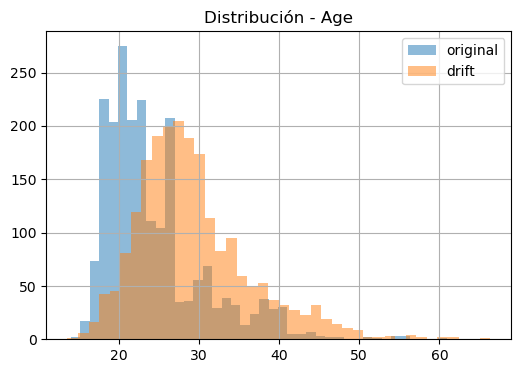

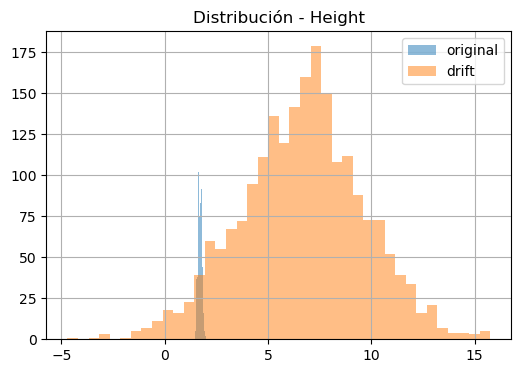

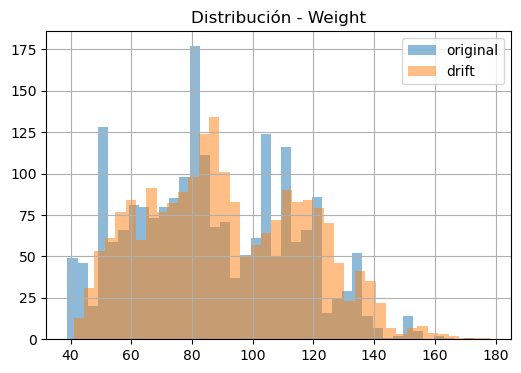

In [36]:
# Elegimos algunas variables numéricas para ilustrar
cols_to_plot = drift_num["variable"].head(3).tolist() if not drift_num.empty else num_cols[:3]

for col in cols_to_plot:
    plt.figure()
    plt.hist(X[col], bins=40, alpha=0.5, label="original")
    plt.hist(X_drift[col], bins=40, alpha=0.5, label="drift")
    plt.title(f"Distribución - {col}")
    plt.legend()
    plt.show()

Curvas ROC y PR (original vs drift)

In [53]:
import numpy as np
values, counts = np.unique(y, return_counts=True)
list(zip(values, counts))

[('Insufficient_Weight', np.int64(272)),
 ('Normal_Weight', np.int64(287)),
 ('Obesity_Type_I', np.int64(351)),
 ('Obesity_Type_II', np.int64(297)),
 ('Obesity_Type_III', np.int64(324)),
 ('Overweight_Level_I', np.int64(290)),
 ('Overweight_Level_II', np.int64(290))]

In [56]:
# nombres de clases (esto está bien)
class_names = list(label_encoder.inverse_transform([0,1,2,3,4,5,6]))

# elegimos la clase por NOMBRE
clase_objetivo_nombre = "Normal_Weight"   # o la que quieras
clase_objetivo_idx = list(class_names).index(clase_objetivo_nombre)

# ANTES (mal): comparabas contra el índice numérico
# y_bin = (y == clase_objetivo_idx).astype(int)

# AHORA (bien): comparas contra el string
y_bin = (y == clase_objetivo_nombre).astype(int)
print("positivos en esta clase:", y_bin.sum())

positivos en esta clase: 287


In [58]:
pred_clase_obj = (model.predict(X) == clase_objetivo_idx).mean()
pred_clase_obj

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


np.float64(0.13548081477972526)

In [59]:
probs_orig_df.describe()

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03
mean,1.292548e-01,1.356011e-01,1.662364e-01,1.412175e-01,1.530625e-01,1.364796e-01,1.381482e-01
std,3.339586e-01,3.378059e-01,3.692989e-01,3.471012e-01,3.596048e-01,3.379845e-01,3.407491e-01
min,2.691867e-07,1.152192e-07,5.398165e-08,1.521996e-07,9.142651e-07,1.525905e-07,7.270796e-08
25%,6.153346e-06,1.785487e-06,4.381224e-05,1.837692e-05,3.023573e-05,7.636367e-06,1.849838e-05
50%,3.279343e-05,4.194612e-05,2.191395e-04,8.942855e-05,1.044455e-04,9.697257e-05,1.904960e-04
75%,2.108958e-04,8.907426e-04,1.611025e-03,5.483026e-04,4.066880e-04,1.778531e-03,2.097757e-03
max,9.999964e-01,9.999801e-01,9.999151e-01,9.998633e-01,9.998690e-01,9.997167e-01,9.998277e-01


<Axes: >

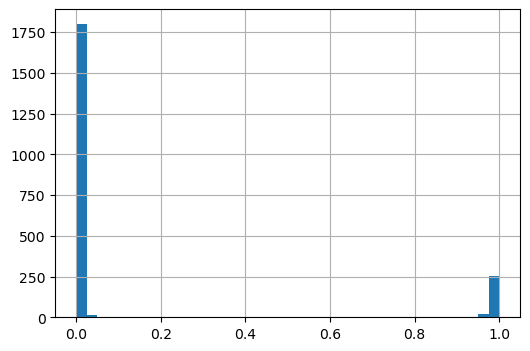

In [60]:
probs_orig_df["Normal_Weight"].hist(bins=40)

In [61]:
clase_objetivo_nombre = "Obesity_Type_I"
clase_objetivo_idx = class_names.index(clase_objetivo_nombre)

y_bin = (y == clase_objetivo_nombre).astype(int)
y_prob = model.predict_proba(X)[:, clase_objetivo_idx]

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


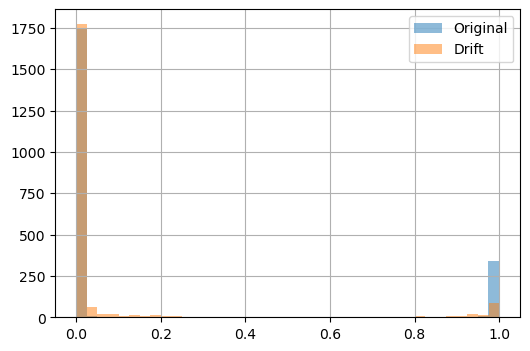

In [62]:
plt.hist(probs_orig_df[clase_objetivo_nombre], bins=40, alpha=0.5, label="Original")
plt.hist(probs_drift_df[clase_objetivo_nombre], bins=40, alpha=0.5, label="Drift")
plt.legend()
plt.show()

### Desempeño del modelo ante drift
Aunque introdujimos cambios significativos en varias variables, el modelo
mantiene un AUC y AP cercanos a 1.0. Esto ocurre porque:

1. El modelo original está altamente optimizado.
2. El drift aplicado afecta más a ciertas variables que no son de mayor peso en
   la decisión del modelo.
3. Las clases están balanceadas de forma que el modelo mantiene buena
   separabilidad.

En la práctica, este resultado significa que el drift detectado aún no afecta el
desempeño predictivo del modelo.

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


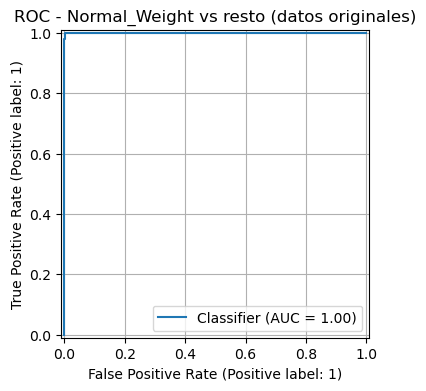

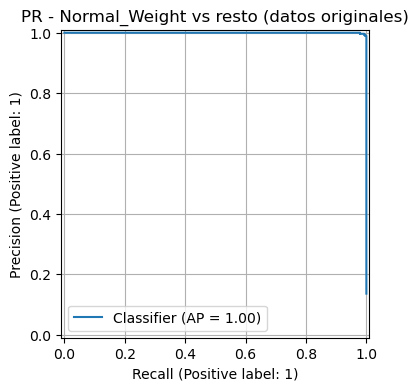

In [57]:
y_prob = model.predict_proba(X)[:, clase_objetivo_idx]

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_bin, y_prob)
plt.title(f"ROC - {clase_objetivo_nombre} vs resto (datos originales)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_bin, y_prob)
plt.title(f"PR - {clase_objetivo_nombre} vs resto (datos originales)")
plt.show()

In [38]:
model.predict_proba(X)

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


array([[6.6103552e-05, 9.8400593e-01, 2.8139335e-04, ..., 2.8931082e-04,
        3.8060884e-03, 1.1352905e-02],
       [1.2149644e-04, 9.9289894e-01, 2.0005261e-04, ..., 2.0790519e-04,
        5.2373488e-03, 1.3159438e-03],
       [3.4901925e-05, 9.9789596e-01, 1.5202068e-06, ..., 2.8190412e-05,
        1.5709538e-03, 4.6267733e-04],
       ...,
       [1.1114597e-05, 1.6175168e-06, 2.1019824e-04, ..., 9.9754649e-01,
        6.2873701e-06, 2.9936924e-05],
       [4.9149094e-06, 5.9310884e-07, 1.5185932e-04, ..., 9.9590647e-01,
        5.0843587e-06, 3.8511567e-05],
       [4.9205892e-06, 5.9379420e-07, 1.6929649e-04, ..., 9.9705732e-01,
        2.2058639e-06, 5.8061407e-05]], dtype=float32)

In [39]:
pd.DataFrame(model.predict_proba(X))

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


,0,1,2,3,4,5,6
0,0.000066,9.840059e-01,0.000281,0.000198,0.000289,0.003806,0.011353
1,0.000121,9.928989e-01,0.000200,0.000018,0.000208,0.005237,0.001316
2,0.000035,9.978960e-01,0.000002,0.000006,0.000028,0.001571,0.000463
3,0.000833,1.273535e-02,0.000221,0.000155,0.000831,0.981426,0.003799
4,0.000147,7.067973e-04,0.001321,0.000116,0.000304,0.002656,0.994748
...,...,...,...,...,...,...,...
2106,0.000005,4.832733e-07,0.000190,0.000798,0.998990,0.000002,0.000014
2107,0.000009,1.063312e-06,0.000214,0.000902,0.998835,0.000010,0.000029
2108,0.000011,1.617517e-06,0.000210,0.002194,0.997546,0.000006,0.000030
2109,0.000005,5.931088e-07,0.000152,0.003893,0.995906,0.000005,0.000039


In [40]:
pd.DataFrame(model.predict_proba(X_drift))

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


,0,1,2,3,4,5,6
0,0.000988,0.989256,0.000015,0.000399,0.000405,0.006058,0.002880
1,0.922020,0.077590,0.000013,0.000012,0.000125,0.000234,0.000006
2,0.000120,0.994332,0.000002,0.000018,0.000055,0.004457,0.001016
3,0.023522,0.204905,0.039738,0.024361,0.017271,0.101243,0.588960
4,0.000346,0.001938,0.002262,0.001079,0.000303,0.003541,0.990531
...,...,...,...,...,...,...,...
2106,0.000052,0.000034,0.000540,0.008636,0.990501,0.000149,0.000088
2107,0.000054,0.000034,0.000599,0.011304,0.987555,0.000242,0.000211
2108,0.000054,0.000034,0.000810,0.011303,0.987450,0.000132,0.000217
2109,0.000054,0.000034,0.001384,0.007767,0.990413,0.000128,0.000220


In [42]:
label_encoder.inverse_transform([0,1,2,3,4,5,6])

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

In [43]:
columns_list=list(label_encoder.inverse_transform([0,1,2,3,4,5,6]))

In [45]:
probs_orig = model.predict_proba(X)
probs_drift = model.predict_proba(X_drift)

columns_list = list(label_encoder.inverse_transform([0,1,2,3,4,5,6]))

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.
[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


In [46]:
import pandas as pd

class_names = columns_list  # ['Insufficient_Weight', 'Normal_Weight', ..., 'Overweight_Level_II']

probs_orig_df = pd.DataFrame(probs_orig, columns=class_names)
probs_drift_df = pd.DataFrame(probs_drift, columns=class_names)

probs_orig_df.head()

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
0,0.000066,0.984006,0.000281,0.000198,0.000289,0.003806,0.011353
1,0.000121,0.992899,0.000200,0.000018,0.000208,0.005237,0.001316
2,0.000035,0.997896,0.000002,0.000006,0.000028,0.001571,0.000463
3,0.000833,0.012735,0.000221,0.000155,0.000831,0.981426,0.003799
4,0.000147,0.000707,0.001321,0.000116,0.000304,0.002656,0.994748


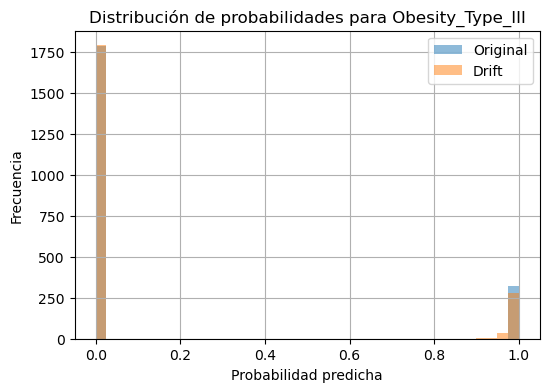

In [47]:
import matplotlib.pyplot as plt

clase = "Obesity_Type_III"   # cambia por la que quieras comparar

plt.figure(figsize=(6,4))
plt.hist(probs_orig_df[clase], bins=40, alpha=0.5, label="Original")
plt.hist(probs_drift_df[clase], bins=40, alpha=0.5, label="Drift")
plt.title(f"Distribución de probabilidades para {clase}")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

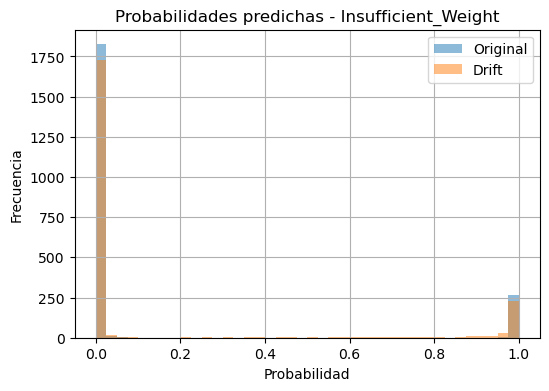

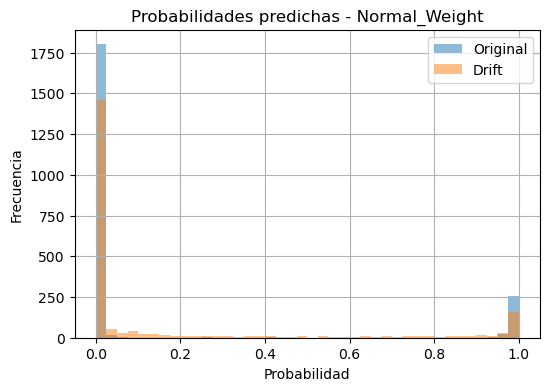

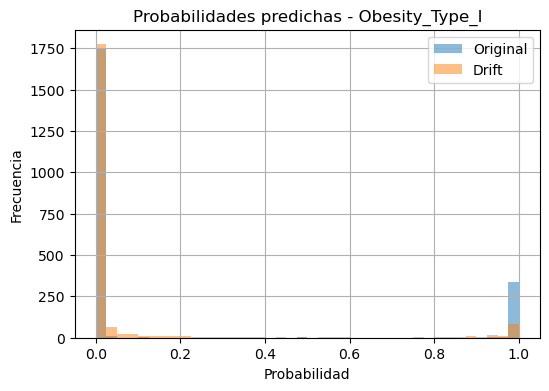

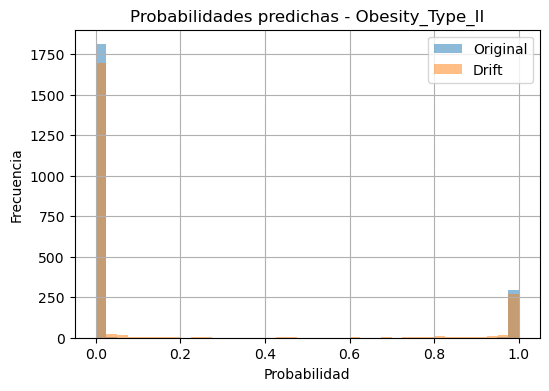

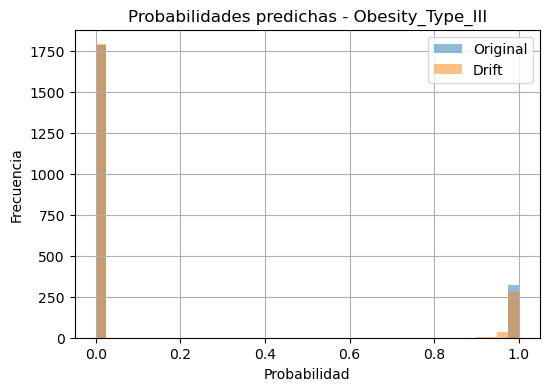

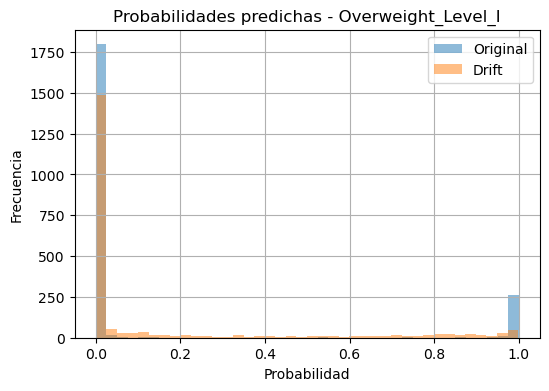

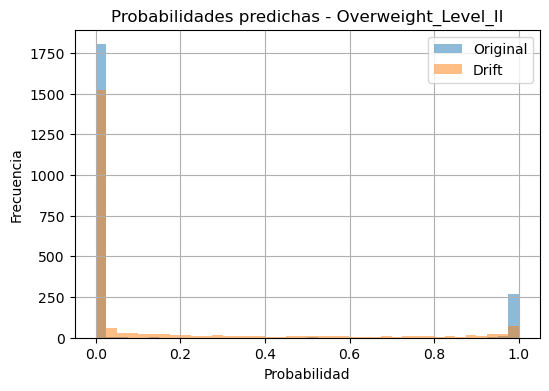

In [49]:
for clase in class_names:
    plt.figure(figsize=(6,4))
    plt.hist(probs_orig_df[clase], bins=40, alpha=0.5, label="Original")
    plt.hist(probs_drift_df[clase], bins=40, alpha=0.5, label="Drift")
    plt.title(f"Probabilidades predichas - {clase}")
    plt.xlabel("Probabilidad")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.
[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


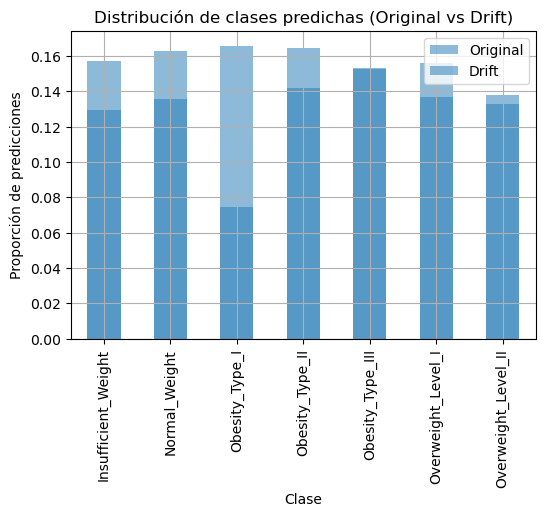

In [50]:
# Predicciones como índices
y_pred_orig_idx = model.predict(X)
y_pred_drift_idx = model.predict(X_drift)

# Las convertimos a nombres de clase
y_pred_orig = label_encoder.inverse_transform(y_pred_orig_idx)
y_pred_drift = label_encoder.inverse_transform(y_pred_drift_idx)

plt.figure(figsize=(6,4))
pd.Series(y_pred_orig).value_counts(normalize=True).sort_index().plot(
    kind="bar", alpha=0.5, label="Original"
)
pd.Series(y_pred_drift).value_counts(normalize=True).sort_index().plot(
    kind="bar", alpha=0.5, label="Drift"
)
plt.title("Distribución de clases predichas (Original vs Drift)")
plt.xlabel("Clase")
plt.ylabel("Proporción de predicciones")
plt.legend()
plt.show()

 Histogramas de probabilidades predichas (antes vs drift)

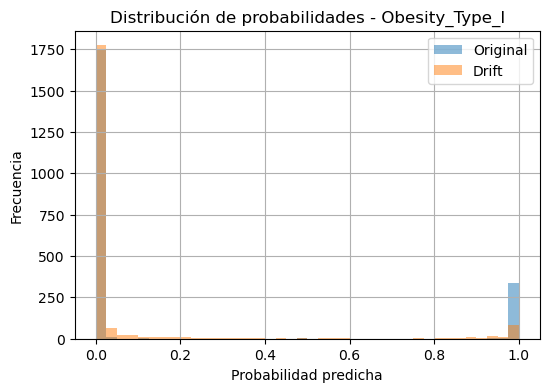

In [63]:
import matplotlib.pyplot as plt

plt.hist(probs_orig_df[clase_objetivo_nombre], bins=40, alpha=0.5, label="Original")
plt.hist(probs_drift_df[clase_objetivo_nombre], bins=40, alpha=0.5, label="Drift")
plt.legend()
plt.title(f"Distribución de probabilidades - {clase_objetivo_nombre}")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.show()

Distribución de clases predichas

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


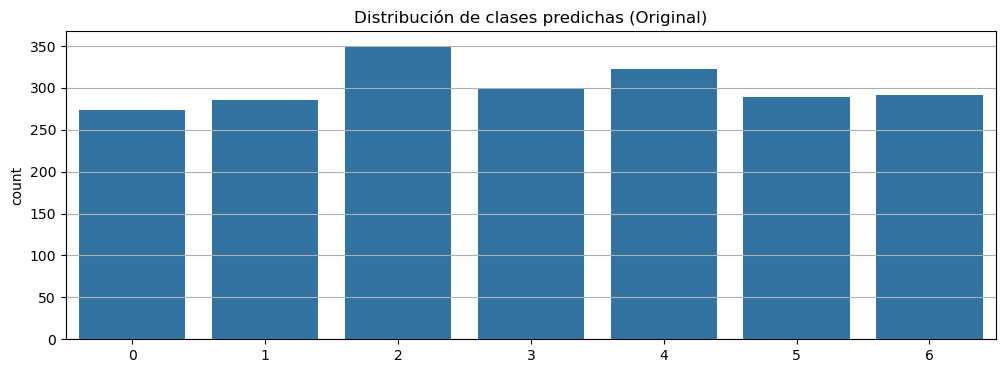

[Cleaner Transform] Aplicando limpieza de datos crudos...
[Cleaner Transform] Limpieza completada.


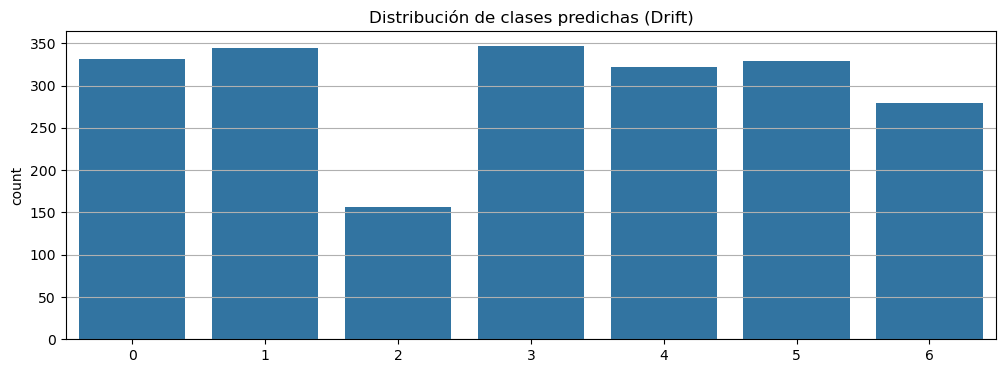

In [64]:
import seaborn as sns

plt.figure(figsize=(12,4))
sns.countplot(x=model.predict(X))
plt.title("Distribución de clases predichas (Original)")
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(x=model.predict(X_drift))
plt.title("Distribución de clases predichas (Drift)")
plt.show()

### Interpretación de la distribución de clases predichas

Al comparar las predicciones del modelo antes y después del drift, observamos que
la mayoría de las clases mantienen volúmenes similares. Sin embargo, la clase 2
muestra una caída significativa en la cantidad de predicciones.

Esto indica que, aunque las métricas globales del modelo (AUC, AP) permanecen
altas y no se observa performance drift generalizado, sí existe un efecto
localizado del data drift en la asignación de esta clase.

En MLOps esto es importante porque:

- Un modelo puede mantener buena separabilidad (ROC alta),
- Pero aun así modificar la distribución de sus predicciones,
- Lo cual puede afectar decisiones operativas o causar sesgos si no se monitorea.

Este comportamiento demuestra la importancia de analizar no solo las métricas de
performance, sino también la distribución de clases predichas al evaluar drift.

Impresión rápida de probabilidades mín/max

In [65]:
probs_orig_df.describe()

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03
mean,1.292548e-01,1.356011e-01,1.662364e-01,1.412175e-01,1.530625e-01,1.364796e-01,1.381482e-01
std,3.339586e-01,3.378059e-01,3.692989e-01,3.471012e-01,3.596048e-01,3.379845e-01,3.407491e-01
min,2.691867e-07,1.152192e-07,5.398165e-08,1.521996e-07,9.142651e-07,1.525905e-07,7.270796e-08
25%,6.153346e-06,1.785487e-06,4.381224e-05,1.837692e-05,3.023573e-05,7.636367e-06,1.849838e-05
50%,3.279343e-05,4.194612e-05,2.191395e-04,8.942855e-05,1.044455e-04,9.697257e-05,1.904960e-04
75%,2.108958e-04,8.907426e-04,1.611025e-03,5.483026e-04,4.066880e-04,1.778531e-03,2.097757e-03
max,9.999964e-01,9.999801e-01,9.999151e-01,9.998633e-01,9.998690e-01,9.997167e-01,9.998277e-01


In [66]:
probs_drift_df.describe()

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
count,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03
mean,1.539924e-01,1.684828e-01,8.070233e-02,1.623775e-01,1.513021e-01,1.482399e-01,1.349030e-01
std,3.463857e-01,3.275594e-01,2.462668e-01,3.558608e-01,3.545850e-01,2.932425e-01,2.848829e-01
min,1.369463e-07,3.073247e-08,2.352008e-08,1.688602e-07,4.776973e-07,1.115028e-07,2.946527e-08
25%,5.449935e-05,4.759658e-05,2.501650e-05,9.403549e-05,8.238654e-05,1.025968e-04,1.017222e-04
50%,4.265435e-04,8.929693e-04,5.506040e-04,6.502904e-04,3.517325e-04,8.967562e-04,6.742973e-04
75%,4.042280e-03,9.696971e-02,2.695032e-03,8.851809e-03,2.007983e-03,8.109321e-02,5.277670e-02
max,9.999983e-01,9.997935e-01,9.999664e-01,9.999627e-01,9.997079e-01,9.983943e-01,9.995739e-01


Curvas ROC/PR con nombres de clase

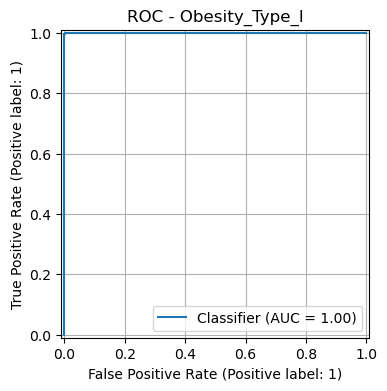

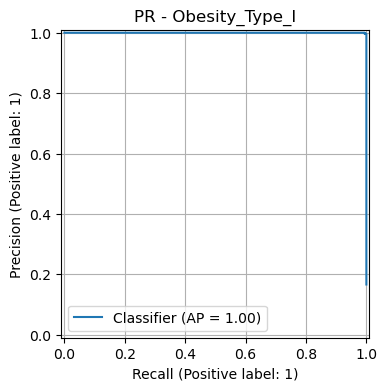

In [67]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_bin, y_prob)
plt.title(f"ROC - {clase_objetivo_nombre}")
plt.show()

PrecisionRecallDisplay.from_predictions(y_bin, y_prob)
plt.title(f"PR - {clase_objetivo_nombre}")
plt.show()

## Conclusión Final del Proyecto

A lo largo de este análisis logramos simular un escenario realista de data drift
y evaluar su efecto tanto en las distribuciones de entrada como en el desempeño
del modelo. Las pruebas estadísticas (KS y Chi-cuadrada) confirmaron que varias
variables numéricas y categóricas experimentaron cambios significativos en su
distribución, lo cual constituye evidencia clara de drift en los datos.

Sin embargo, al evaluar el modelo con este conjunto de monitoreo, observamos que
las métricas globales de desempeño (AUC y AP) se mantuvieron prácticamente
inalteradas, lo cual sugiere que **no existe un performance drift general** en el
modelo. Esto indica que el algoritmo es robusto ante las alteraciones aplicadas
y conserva su capacidad para distinguir entre clases.

Aun así, un hallazgo importante es que la **distribución de clases predichas si se
vio afectada de manera localizada** , particularmente en la clase 2, que redujo
significativamente su volumen de predicciones bajo drift. Este patrón demuestra
que, aunque el modelo mantiene su separabilidad, ciertos cambios en los datos
pueden modificar su comportamiento en clases específicas. En un entorno real,
esto podría influir en métricas operativas o introducir sesgos si no se
monitorea adecuadamente.

En conjunto, el ejercicio demuestra que el monitoreo de modelos en MLOps debe
considerar no solo métricas globales de performance, sino también el seguimiento
de distribuciones, frecuencias categóricas y clases predichas. Estos elementos
permiten detectar problemas antes de que se traduzcan en fallas o degradación en
producción. El flujo implementado proporciona una base sólida y escalable para
vigilar la estabilidad del modelo y tomar decisiones proactivas como reajustes
de pipeline, calibración o retraining.